# Classification Origin

Papers:

https://www.semanticscholar.org/paper/Music-and-Geography%3A-Content-Description-of-Musical-G%C3%B3mez-Haro/4d48f2eaefc6a8336149e4cca1c5d2264969f223#paper-topics
https://www.geographyrealm.com/the-geography-of-music/
https://www.cambridge.org/core/journals/organised-sound/article/marsyas-a-framework-for-audio-analysis/43A5D9BCB0F7BB439E1D4D1FF4B563C2
https://archive.ics.uci.edu/dataset/315/geographical+original+of+music



In [1]:
import csv
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Import the colormap module
import folium
from scipy.spatial import Voronoi
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing



In [2]:
music_origin_data = pd.read_csv('./data/kaggle/Music_origin.csv')
music_origin_cr_data = pd.read_csv('./data/kaggle/Music_origin_chromatic.csv')
gdf_bondaries = gpd.read_file('./data/countries/world-administrative-boundaries.shp')

music_origin_data.drop('Unnamed: 0',axis=1,inplace=True)
music_origin_cr_data.drop('Unnamed: 0',axis=1,inplace=True)

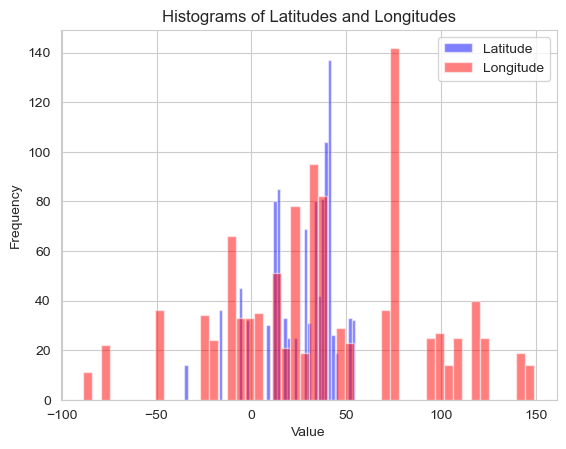

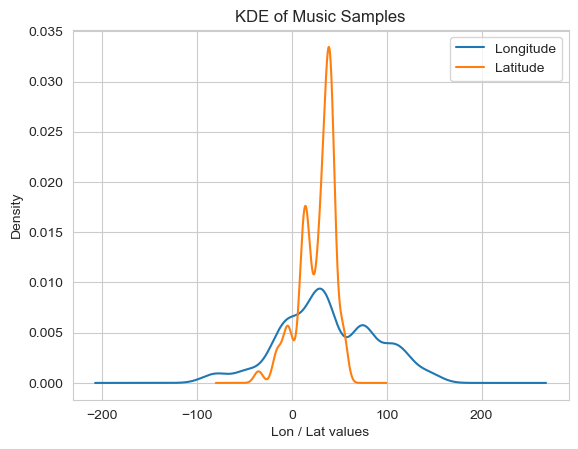

In [3]:
with open('./data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))

plt.hist(music_origin_data["Latitude"], bins=50, alpha=0.5, color='blue', label='Latitude')
plt.hist(music_origin_data["Longitude"], bins=50, alpha=0.5, color='red', label='Longitude')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histograms of Latitudes and Longitudes')
plt.savefig('./images/02_hist_lat_lon.png')
plt.show()



music_origin_data[["Longitude","Latitude"]].plot.kde()
plt.xlabel('Lon / Lat values')
plt.title('KDE of Music Samples')
plt.savefig('./images/03_KDE_lat_lon.png')
plt.show()

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\claud\AppData\Local\Temp\ipykernel_19220\968951337.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()
C:\Users\claud\AppData\Local\Temp\ipykernel_19220\968951337.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nearest_polygon_attributes['geometry'] = point_geom
C:\Users\claud\AppData\Local\Temp\ipyk

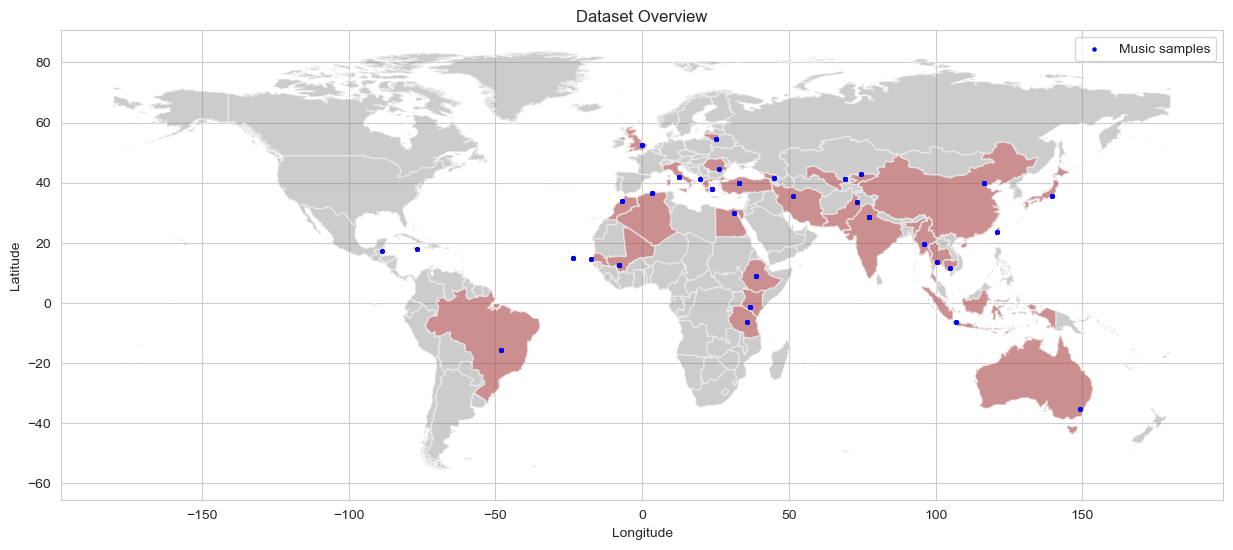

In [4]:
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster


geometry = [Point(xy) for xy in zip(music_origin_data['Longitude'], music_origin_data['Latitude'])]
music_origin_gdf = gpd.GeoDataFrame(music_origin_data, geometry=geometry, crs="EPSG:4326")
music_origin_gdf = gpd.sjoin(music_origin_gdf, gdf_bondaries, how="left", op="within")
unmatched_points = music_origin_gdf[music_origin_gdf['iso3'].isna()].copy()

for idx, point in unmatched_points.iterrows():
    point_geom = point['geometry']
    nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()
    nearest_polygon_attributes = gdf_bondaries.loc[nearest_polygon_idx]
    nearest_polygon_attributes['geometry'] = point_geom
    music_origin_gdf.loc[idx, music_origin_gdf.columns.intersection(nearest_polygon_attributes.index)] = nearest_polygon_attributes

music_origin_gdf = music_origin_gdf.drop(columns=['index_right']).rename(columns={'index_left': 'index'})


plt.figure(figsize=(15,10))
music_origin_gdf_filtered = gdf_bondaries[gdf_bondaries['iso3'].isin(music_origin_gdf['iso3'])]
music_origin_gdf_filtered.plot(ax=plt.gca(), color='red', alpha=0.4, label='Shapefile')
gdf_bondaries.plot(ax=plt.gca(), color='gray', alpha=0.4, label='Shapefile')
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=5, color = "blue",label = 'Music samples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dataset Overview')
plt.legend()
plt.savefig('./images/01_Dataset_overview.png')
plt.show()

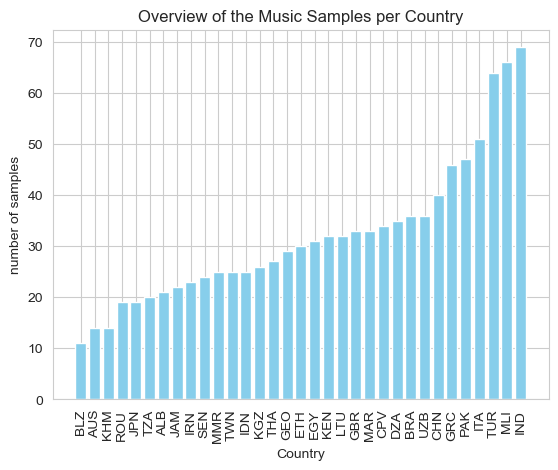

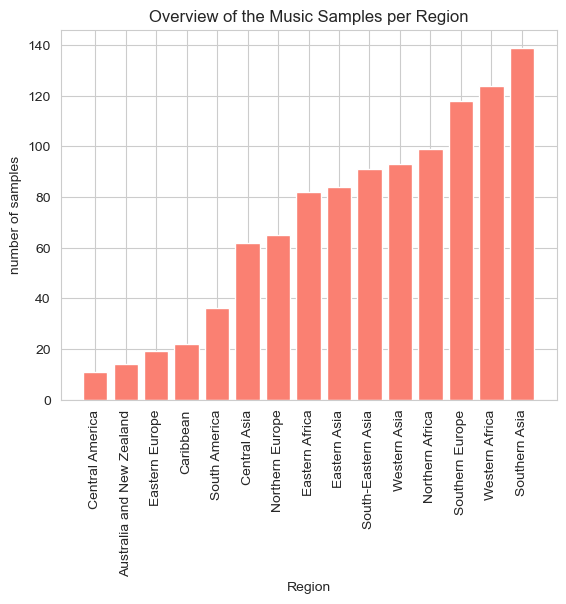

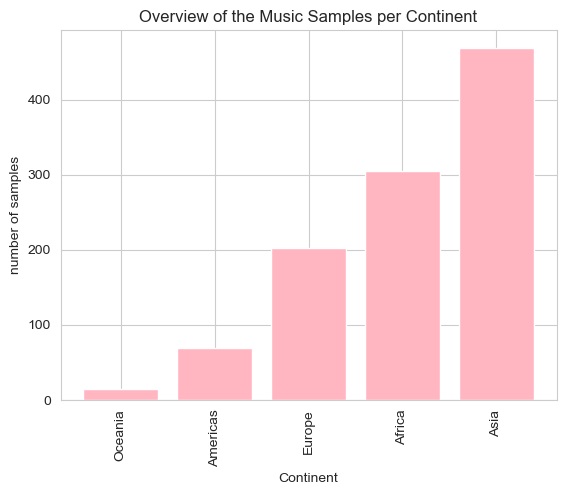

In [5]:
per_country = music_origin_gdf.groupby('iso3').nunique().reset_index().sort_values('Feature1')
plt.bar(per_country["iso3"],per_country["Feature1"], color = "skyblue")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Country")
plt.ylabel("number of samples")
plt.xlabel("Country")
plt.savefig('./images/04_Overview_music_per_country.png')
plt.show()

per_region = music_origin_gdf.groupby('region').nunique().reset_index().sort_values('Feature1')
plt.bar(per_region["region"],per_region["Feature1"], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.savefig('./images/05_Overview_music_per_region.png')
plt.show()

per_continent = music_origin_gdf.groupby('continent').nunique().reset_index().sort_values('Feature1')
plt.bar(per_continent["continent"],per_continent["Feature1"], color = "lightpink")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Continent")
plt.ylabel("number of samples")
plt.xlabel("Continent")
plt.savefig('./images/06_Overview_music_per_continent.png')
plt.show()

# Have a Look at the 68 Features

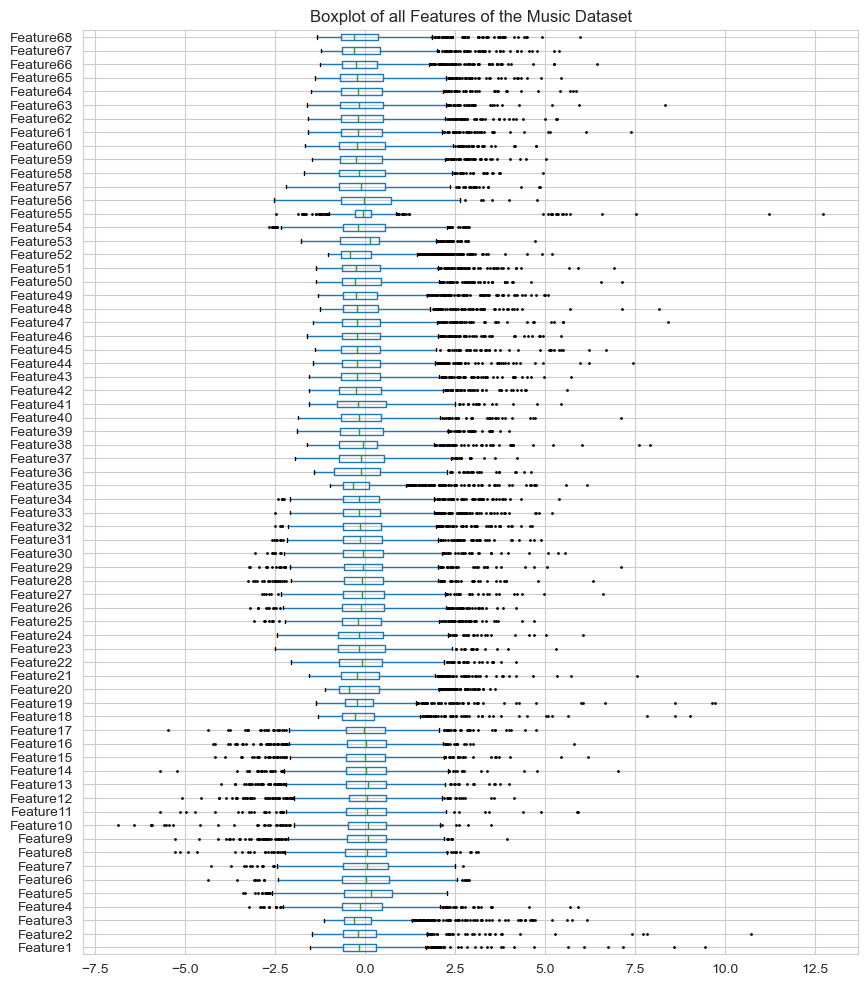

In [6]:
plt.figure(figsize=(10, 12))
music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                        'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                        'french_shor'],axis=1).boxplot(vert=False,
                                                       flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset")
plt.savefig('./images/07_Boxplot_68Features.png')

There are alot of features, thus it could be an idea, to make a Principle Component Analysis to reduce the number of features.

# PCA

In [7]:
#make PCA:
scaler = preprocessing.StandardScaler()
music_origin_gdf_scaled = scaler.fit_transform(music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                                                                      'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                      'french_shor'],axis=1))
nums = np.arange(68)
var_ratio = []
for num in nums:
    pca = PCA(n_components=num).fit(music_origin_gdf_scaled)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

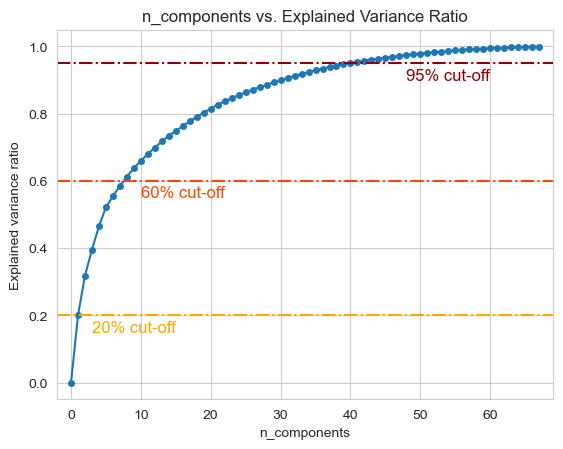

In [8]:
plt.plot(nums,var_ratio,marker='o',markersize = 4)
plt.xlim(-2,69)
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.axhline(y=0.95, color='darkred', linestyle='-.')
plt.text(48, 0.9, '95% cut-off', color = 'darkred', fontsize=12)
plt.axhline(y=0.6, color='orangered', linestyle='-.')
plt.text(10, 0.55, '60% cut-off ', color = 'orangered', fontsize=12)
plt.axhline(y=0.2, color='orange', linestyle='-.')
plt.text(3, 0.15, '20% cut-off', color = 'orange', fontsize=12)
plt.savefig('./images/08_PCA_n_comp_vs_variance3.png')

In [9]:
music_origin_gdf_filtered = music_origin_gdf_filtered.merge(music_origin_gdf["iso3"],on = "iso3")
music_origin_gdf_filtered["iso3"].unique()

array(['DZA', 'JAM', 'BLZ', 'MAR', 'TUR', 'LTU', 'UZB', 'CPV', 'ITA',
       'IRN', 'ETH', 'KGZ', 'GBR', 'SEN', 'GRC', 'IDN', 'PAK', 'EGY',
       'IND', 'THA', 'AUS', 'TWN', 'BRA', 'KHM', 'GEO', 'CHN', 'ROU',
       'TZA', 'MMR', 'JPN', 'MLI', 'ALB', 'KEN'], dtype=object)

Okay, we choose the 95% cut-off beacuse then we have 95% of the variance explained, which is quite good.

Number of components to reach 95% cutoff: 41
Number of components to reach 60% cutoff: 9
Number of components to reach 20% cutoff: 3


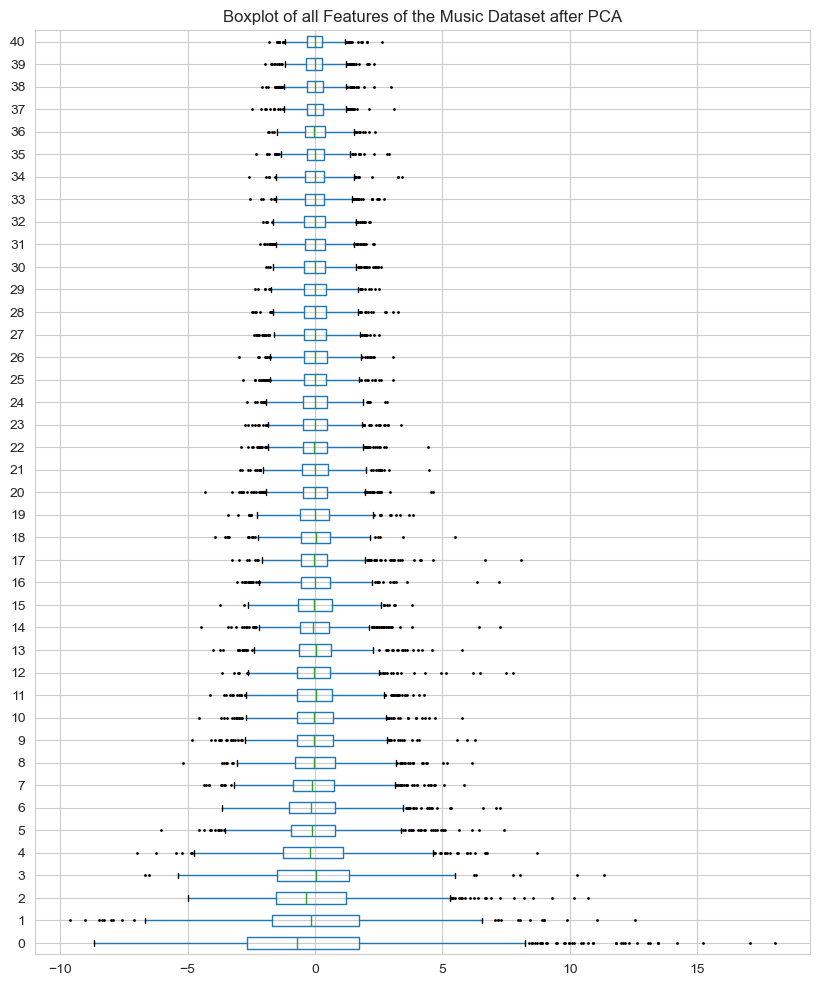

In [10]:
def get_num_components(percent,var_ratio = var_ratio):
    num_components_XX_percent = np.argmax(np.array(var_ratio) >= percent/100) + 1
    #print(f"Number of components to reach {percent}% cutoff: {num_components_XX_percent}")
    return num_components_XX_percent

print(f"Number of components to reach 95% cutoff: {get_num_components(95)}")
print(f"Number of components to reach 60% cutoff: {get_num_components(60)}")
print(f"Number of components to reach 20% cutoff: {get_num_components(20)}")

#make PCA with 95% cutoff
music_origin_pca= pd.DataFrame(PCA(n_components=get_num_components(95)).fit_transform(music_origin_gdf_scaled))
music_origin_gdf_pca = music_origin_pca.merge(music_origin_gdf.loc[:,['Latitude', 'Longitude', 'iso3',
                                                                          'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                          'french_shor']], left_index=True, right_index=True)


plt.figure(figsize=(10, 12))
music_origin_pca.boxplot(vert=False, flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset after PCA")
plt.savefig('./images/09_Boxplot_68Features_PCA.png')


# Clustering

To make this problem to a classification problem, we have to define clusters in order to classify the music samples

## Manual Clustering (geographic boundaries made by humans)

In [11]:
#By region
gdf_regions = gdf_bondaries.dissolve(by='region')
gdf_regions["region"] = gdf_regions.index
gdf_regions1 = gdf_regions[gdf_regions["region"].isin(music_origin_gdf_pca.region.unique())]

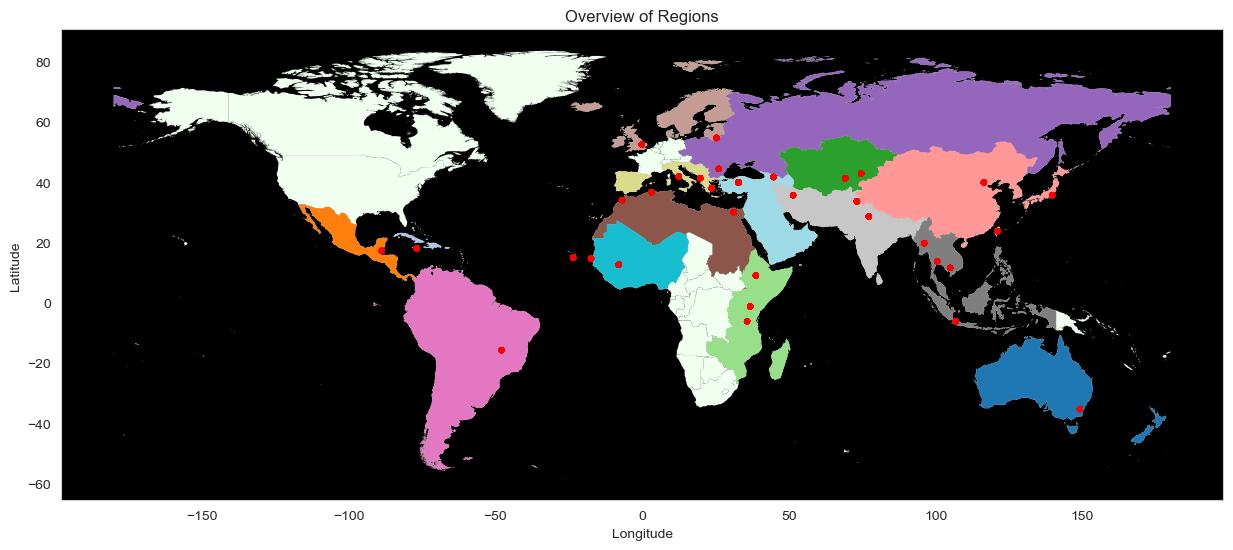

In [12]:
plt.figure(figsize=(15,10))
gdf_bondaries.plot(ax=plt.gca(), color = "honeydew",edgecolor = "none")
gdf_regions1.plot(ax=plt.gca(), column='region', cmap="tab20", alpha=1, legend=False, label='World Regions',edgecolor = "none")
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=20, color = "red",label = 'Music samples',edgecolor = "none")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().set_facecolor("black")
plt.grid(False)
plt.title("Overview of Regions")
plt.savefig('./images/10_Clustering_region.png')

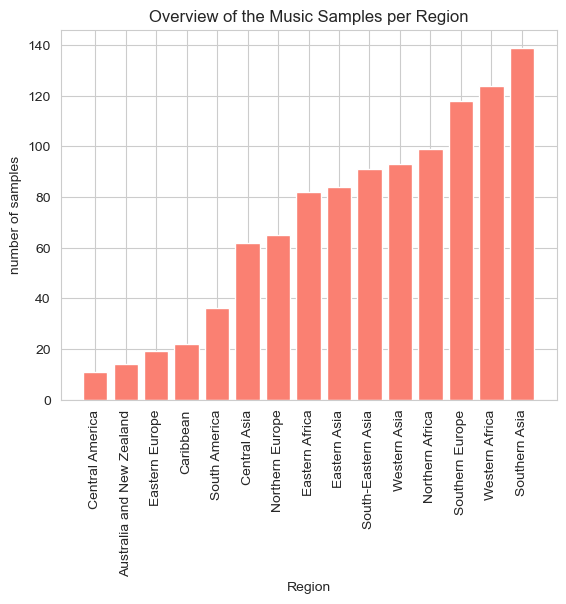

In [13]:
per_region = music_origin_gdf_pca.groupby('region').nunique().reset_index().sort_values(1)
plt.bar(per_region["region"],per_region[1], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()

As seen here, we can see that the clusters are not equally distributed, which can lead to a false good prediction, because the chances that it lies in southern Asia is about the same. We try now to DBSCAN the points to clusters.

## Automatic Clustering (DBScan Method)

In [14]:
# Standardize the data
from sklearn.cluster import DBSCAN
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(music_origin_gdf_pca[["Longitude","Latitude"]])
dbscan = DBSCAN(eps=0.5, min_samples=2)  # You may need to adjust eps and min_samples
music_origin_gdf_pca['Cluster'] = dbscan.fit_predict(scaled_data)

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

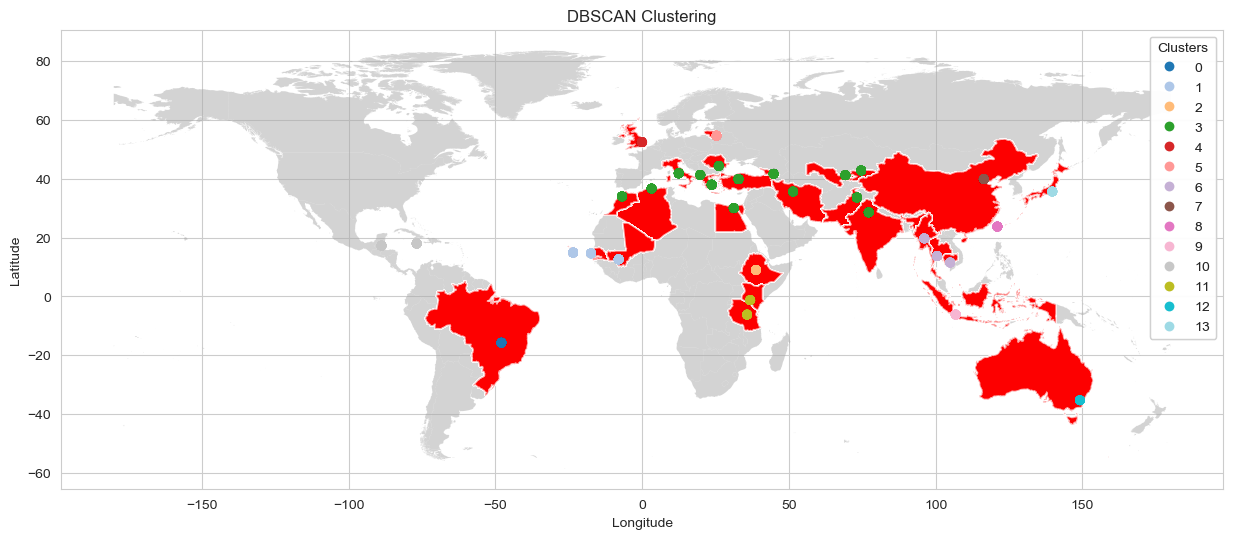

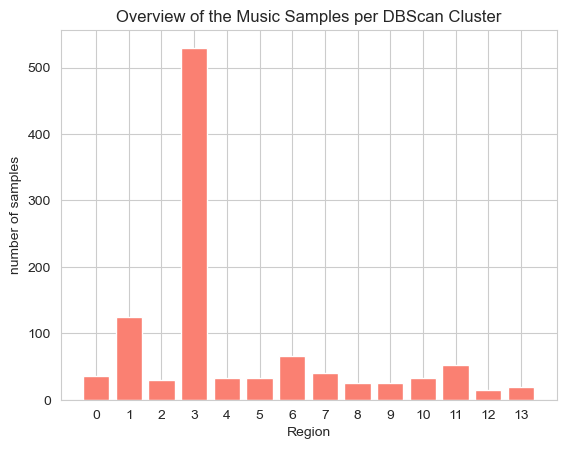

In [15]:
plt.figure(figsize=(15,10))
gdf_bondaries.plot(ax=plt.gca(), alpha=0.5, color = "darkgrey",edgecolor = "none")
scatter = plt.scatter(music_origin_gdf['Longitude'], music_origin_gdf['Latitude'], c=music_origin_gdf_pca['Cluster'], cmap='tab20', label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)  # Add the legend back to the plot
plt.savefig('./images/11_DBSCAN_Clusters.png')
plt.show()

per_DBCluster = music_origin_gdf_pca.groupby("Cluster").nunique()[0].reset_index().sort_values(0)
plt.bar(per_DBCluster["Cluster"],per_DBCluster[0], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per DBScan Cluster")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.xticks(per_DBCluster["Cluster"],rotation = "horizontal")
plt.savefig('./images/12_Overview_DBSCAN_Clusters.png')

plt.show()



# Classification Region cluster

In [16]:
from sklearn.model_selection import train_test_split
from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
import catboost as cb

music_origin_gdf_pca_ml = music_origin_gdf_pca.drop(['Latitude', 'Longitude',
                                                      'status', 'color_code', 'name', 'iso3', 'iso_3166_1_',
                                                      'french_shor','continent','Cluster'],axis = 1)


start_time = datetime.now()

X_train, X_test, y_train, y_test = train_test_split(music_origin_gdf_pca_ml.drop("region",axis = 1), music_origin_gdf_pca_ml['region'], test_size=0.2)



param_grid = {
    'iterations': [1000],
    'depth': [5],
'learning_rate': [0.2]
}
#define the scorer, in this case we can use the mean squared error:
scorer = make_scorer(accuracy_score)


rfc = cb.CatBoostClassifier()

#make the GridSearch:

grid_search = GridSearchCV(
estimator=rfc,
param_grid=param_grid,
scoring=scorer,
cv=5,
n_jobs=-1,
refit='mse',
verbose=10,
)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_



end_time = datetime.now()
print(f'Finished in: {end_time-start_time}')

best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_accuracy)

C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.6131708	total: 154ms	remaining: 2m 34s
1:	learn: 2.5443477	total: 165ms	remaining: 1m 22s
2:	learn: 2.4607755	total: 174ms	remaining: 57.8s
3:	learn: 2.3957849	total: 181ms	remaining: 45.2s
4:	learn: 2.3369026	total: 188ms	remaining: 37.5s
5:	learn: 2.2654288	total: 198ms	remaining: 32.8s
6:	learn: 2.2227552	total: 208ms	remaining: 29.4s
7:	learn: 2.1797231	total: 217ms	remaining: 26.8s
8:	learn: 2.1368298	total: 225ms	remaining: 24.8s
9:	learn: 2.0925731	total: 234ms	remaining: 23.2s
10:	learn: 2.0449955	total: 243ms	remaining: 21.8s
11:	learn: 2.0172497	total: 251ms	remaining: 20.7s
12:	learn: 1.9718031	total: 260ms	remaining: 19.7s
13:	learn: 1.9356671	total: 269ms	remaining: 18.9s
14:	learn: 1.9052770	total: 278ms	remaining: 18.2s
15:	learn: 1.8639541	total: 286ms	remaining: 17.6s
16:	learn: 1.8420066	total: 294ms	remaining: 17s
17:	learn: 1.8100501	total: 303ms	remaining: 16.5s
18:	learn: 1.7892144	total: 312ms

# Idea: SMOTE
The classes are quite inbalanced. So there exist more insstances in class X than in class Y. An option is to syntheticly generate data for the less representative class. perhaps this could improve the classes?
1. -> create artificial datapoints to train the data accordingly good
2. Train the model with the artificial points
3. Test set is the old set!


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

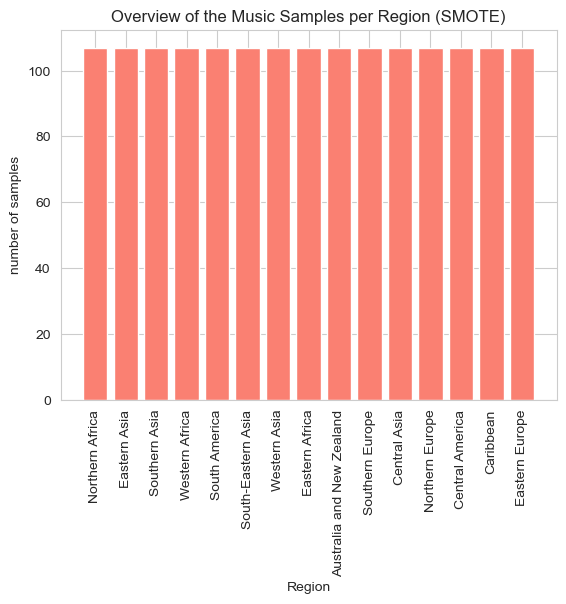

In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
per_region = pd.DataFrame(y_train_resampled.value_counts()).reset_index()
plt.bar(per_region["region"], per_region['count'], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region (SMOTE)")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()

In [18]:
start_time = datetime.now()
grid_search.fit(X_train_resampled,y_train_resampled)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_accuracy = grid_search.best_score_
end_time = datetime.now()
print("Best Parameters:", best_params)
print("Best Accuracy Score:", best_accuracy)
print(f'Finished in: {end_time-start_time}')


C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\claud\anaconda3\envs\GEO871\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.5295142	total: 13.2ms	remaining: 13.2s
1:	learn: 2.3186137	total: 22.7ms	remaining: 11.3s
2:	learn: 2.2258075	total: 31.9ms	remaining: 10.6s
3:	learn: 2.1315433	total: 41.3ms	remaining: 10.3s
4:	learn: 2.0444031	total: 50.6ms	remaining: 10.1s
5:	learn: 1.9579320	total: 60ms	remaining: 9.95s
6:	learn: 1.8839650	total: 69.4ms	remaining: 9.84s
7:	learn: 1.8093806	total: 79ms	remaining: 9.79s
8:	learn: 1.7615813	total: 88.2ms	remaining: 9.71s
9:	learn: 1.7035554	total: 97.4ms	remaining: 9.64s
10:	learn: 1.6624752	total: 106ms	remaining: 9.57s
11:	learn: 1.6190904	total: 115ms	remaining: 9.49s
12:	learn: 1.5697959	total: 124ms	remaining: 9.43s
13:	learn: 1.5201003	total: 134ms	remaining: 9.41s
14:	learn: 1.4762291	total: 143ms	remaining: 9.39s
15:	learn: 1.4357561	total: 153ms	remaining: 9.41s
16:	learn: 1.4025720	total: 162ms	remaining: 9.39s
17:	learn: 1.3685606	total: 172ms	remaining: 9.39s
18:	learn: 1.3388346	total:

# Presentation / Appendix / Visualisation for explanation

In [50]:
from pytube import YouTube

def download_video(url, output_path='./data/'):
    yt = YouTube(url)
    audio_stream = yt.streams.filter(only_audio=True).first()
    audio_stream.download(output_path)
    print(f"Video downloaded successfully to {output_path}")

download_video(input("Enter the YouTube video URL: "))



# https://stackoverflow.com/questions/55081352/how-to-convert-mp4-to-mp3-using-python
from moviepy.editor import *
def MP4ToMP3(mp4, mp3): 
    FILETOCONVERT = AudioFileClip(mp4)
    FILETOCONVERT.write_audiofile(mp3)
    FILETOCONVERT.close()
VIDEO_FILE_PATH = r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp4"
AUDIO_FILE_PATH =  r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp3"
MP4ToMP3(VIDEO_FILE_PATH, AUDIO_FILE_PATH)

        


RegexMatchError: regex_search: could not find match for (?:v=|\/)([0-9A-Za-z_-]{11}).*

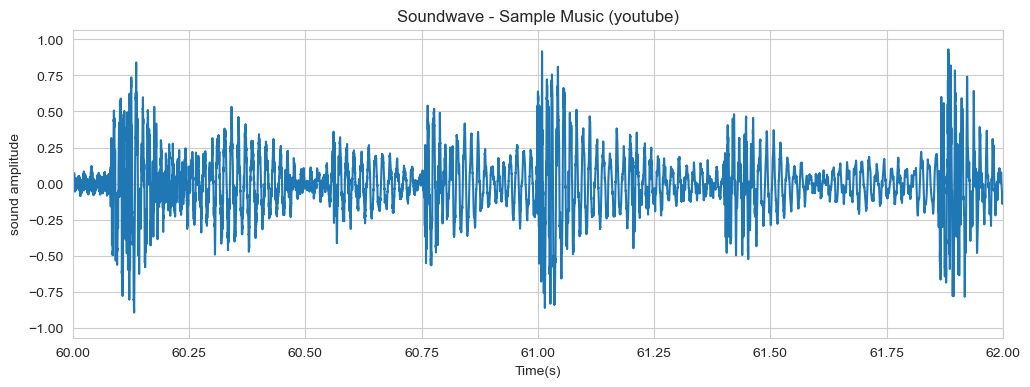

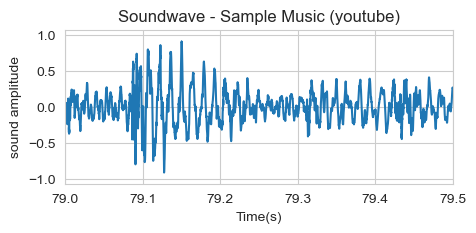

[0.161, 0.164, 0.159, 0.155, 0.148, 0.147, 0.141, 0.137, 0.136, 0.134, 0.135, 0.132, 0.126, 0.122, 0.118, 0.116, 0.116, 0.112, 0.112, 0.12, 0.121, 0.124, 0.126, 0.129, 0.136, 0.135, 0.141, 0.146, 0.15, 0.157, 0.161, 0.165, 0.17, 0.17, 0.175, 0.185, 0.183, 0.181, 0.183, 0.182, 0.195, 0.209, 0.193, 0.18, 0.189, 0.193, 0.186, 0.181, 0.185, 0.185]


In [102]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_wavelength(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)
    time = np.arange(0,len(y))/sr
    plt.figure(figsize=(12, 4))
    plt.plot(time,y)
    plt.xlim(60,62)
    plt.xlabel("Time(s)")
    plt.ylabel('sound amplitude')
    plt.title("Soundwave - Sample Music (youtube)")
    plt.savefig('./images/13_Soundwave_big.png')
    plt.show()

    plt.figure(figsize=(5, 2))
    plt.plot(time,y)
    plt.xlim(79,79.5)
    plt.xlabel("Time(s)")
    plt.ylabel('sound amplitude')
    plt.title("Soundwave - Sample Music (youtube)")
    plt.savefig('./images/14_Soundwave_small_2.png')
    plt.show()

    
    print(list(np.round(y[5000:5050], 3)))




plot_wavelength(r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp3")


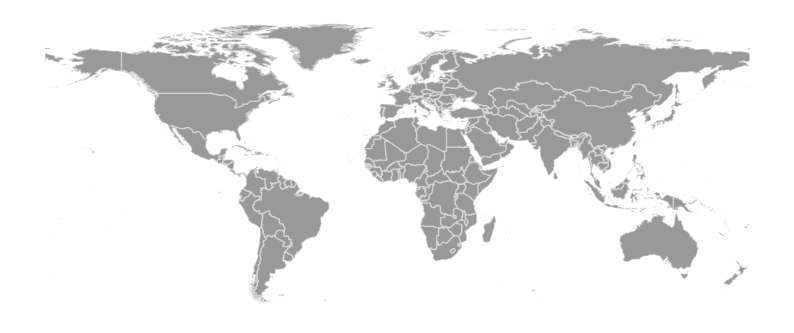

In [94]:
plt.figure(figsize=(10, 5))
gdf_bondaries.plot(ax=plt.gca(), color='black', alpha=0.4)
plt.axis('off')
plt.savefig('./images/15_map.png')
